<a href="https://colab.research.google.com/github/Nikbert/EPI_simulations/blob/main/Copy_of_01_write_and_simulate_basic_EPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example EPI sequence
(adopted from https://github.com/imr-framework/pypulseq/blob/dev/pypulseq/seq_examples/scripts/write_epi.py with many modifications)

For the first-time use select Runtime->Run All (or hit Ctrl+F9) as thie initial setup of the environment takes about a minute. In a mean time scroll down to familiarize yourself with the sequence code.

The exercises are at the at of the notebook

# Initial package set-up
This is a necessary step for the Colab environment, and it is only slow on the first run

In [1]:
try:
  import pypulseq as mr
  import sigpy as sp
  #!wget https://raw.githubusercontent.com/Nikbert/EPI_simulations/main/Models/cropped_phantom.mat
  # Niklas mod of Frank's utils that uses the phantom model for simulation
  #!wget https://raw.githubusercontent.com/Nikbert/EPI_simulations/main/utils/utils.py
  print("pypulseq package is readily available\n")

except ImportError or ModuleNotFoundError:
  !pip install git+https://github.com/imr-framework/pypulseq.git
  !pip install sigpy
  #!pip install git+https://github.com/FrankZijlstra/pypulseq.git@bugfixes
  !pip install -q mrzerocore git+https://github.com/imr-framework/pypulseq.git
  # Frank's utils
  #!wget https://raw.githubusercontent.com/pulseq/MR-Physics-with-Pulseq/main/utils/utils.py
  # Niklas mod of Frank's utils that uses the phantom model for simulation
  !wget https://raw.githubusercontent.com/Nikbert/EPI_simulations/main/utils/utils.py
  #!wget https://raw.githubusercontent.com/Nikbert/EPI_simulations/main/Models/cropped_phantom.mat
  !wget https://raw.githubusercontent.com/Nikbert/EPI_simulations/main/measured_line_center_offsets/diff_center_kx_c_even.npy
  !wget https://raw.githubusercontent.com/Nikbert/EPI_simulations/main/measured_line_center_offsets/diff_center_kx_c_odd.npy
  !wget https://raw.githubusercontent.com/Nikbert/EPI_simulations/main/measured_line_center_offsets/diff_center_kx_p_even.npy
  !wget https://raw.githubusercontent.com/Nikbert/EPI_simulations/main/measured_line_center_offsets/diff_center_kx_p_odd.npy

  # for simulation
  #!pip show MRzeroCore || pip install MRzeroCore
  #!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/util.py &> /dev/null
  #!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null


  Cloning https://github.com/imr-framework/pypulseq.git to /tmp/pip-req-build-e80muqpm
  Running command git clone --filter=blob:none --quiet https://github.com/imr-framework/pypulseq.git /tmp/pip-req-build-e80muqpm
  Resolved https://github.com/imr-framework/pypulseq.git to commit 2f09cf69aeef4f6332786151f4561712b05dbafa
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.7/234.7 kB 6.0 MB/s eta 0:00:00
  Created wheel for pypulseq: filename=pypulseq-1.4.2-py3-none-any.whl size=182744 sha256=9f31d8499886702bf96d3b7230391173c06c5b299239405fdd79296b63d3c78c
  Stored in directory: /tmp/pip-ephem-wheel-cache-a_b7egxn/wheels/b3/3c/2d/4615def3ba2cf9a2c9b356df4563e66a9893931bf1c566339f
Successfully built pypulseq
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 59.2 MB/s eta 0:0

# Python imports

In [2]:
%load_ext autoreload
%autoreload 2

import math
import warnings
import numpy as np
import sigpy as sp
from matplotlib import pyplot as plt

import pypulseq as mr

# Frank's utils
#import utils # several helper functions for simulation and recon
#import MRzeroCore as mr0
from utils import animate, simulate_2d, reconstruct

/usr/local/lib/python3.10/dist-packages/sigpy/config.py:15: UserWarning: Importing cupy failed. For more details, see the error stack below:

Failed to import CuPy.

If you installed CuPy via wheels (cupy-cudaXXX or cupy-rocm-X-X), make sure that the package matches with the version of CUDA or ROCm installed.

On Linux, you may need to set LD_LIBRARY_PATH environment variable depending on how you installed CUDA/ROCm.
On Windows, try setting CUDA_PATH environment variable.

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

Original error:
  ImportError: libcuda.so.1: cannot open shared object file: No such file or directory

  warnings.warn(


# Set high-level sequence parameters
Use the code block below to set high-level parameters such as FOV, spatial resolution, etc...

In [3]:
# Define FOV, resolution and other parameters
fov = 220e-3
Nx = 64 #60
Ny = 64 #60
slice_thickness = 4e-3  # Slice thickness
n_slices = 1
ro_duration=520e-6 #1200e-6 # duration of the ADC / readout event, defailt: 1200us, 240us still works
rf_duration=2.5e-3

# Set system limits
system = mr.Opts(
    max_grad=32,
    grad_unit="mT/m",
    max_slew=130,
    slew_unit="T/m/s",
    rf_ringdown_time=20e-6,
    rf_dead_time=100e-6,
    adc_dead_time=10e-6,
)

# More advansed options and switches. you may chose to disable some of these options to save time in the exercises
plot: bool = True
animate_seq: bool = True
simulate: bool = True
write_seq: bool = True
seq_filename: str = "epi_pypulseq.seq"

# Create Pulseq objects
Create all kinds of objects that we will need in the sequence, such as the slice selective RF pulse, slice selection and refocusing gradients, etc...

In [4]:
# Create 90 degree slice selection pulse and gradient
rf, gz, gz_reph = mr.make_sinc_pulse(
    flip_angle=np.pi / 2,
    system=system,
    duration=rf_duration,
    slice_thickness=slice_thickness,
    apodization=0.5,
    time_bw_product=4,
    return_gz=True,
)

# Define other gradients and ADC events
delta_k = 1 / fov
k_width = Nx * delta_k
print('delta_k',delta_k)
print('k_width',k_width)
dwell_time = ro_duration / Nx
flat_time = np.ceil(ro_duration / system.grad_raster_time) * system.grad_raster_time  # round-up to the gradient raster
gx = mr.make_trapezoid(
    channel="x",
    system=system,
    amplitude=k_width / ro_duration,
    flat_time=flat_time,
)



gx_even = mr.make_trapezoid(
    channel="x",
    system=system,
    #amplitude = (k_width + 0.05) / ro_duration,
    amplitude = (k_width) / ro_duration,
    flat_time=flat_time,
)



gx_odd = mr.make_trapezoid(
    channel="x",
    system=system,
    #amplitude = (k_width) / ro_duration - 0.127,
    amplitude = -(k_width) / ro_duration,
    flat_time=flat_time,
)

#amplitude = (k_width) / ro_duration - 0.127,
#amplitude2 = (k_width - delta_k/2) / ro_duration,

#print('amplitude',amplitude)
#print('amplitude2',amplitude2)

adc = mr.make_adc(
    num_samples=Nx,
    duration=ro_duration,
    delay=gx.rise_time + flat_time / 2 - (dwell_time*Nx) / 2,
    system=system,
)

# Pre-phasing gradients (in the shortest possible time or filling the available time)
gx_pre = mr.make_trapezoid(
    channel="x", system=system, area=-gx.area / 2, duration=mr.calc_duration(gz_reph),
)
gy_pre = mr.make_trapezoid(
    channel="y", system=system, area=(Ny / 2 - 1) * delta_k, duration=mr.calc_duration(gz_reph),
)

# align gradients (calculate their delays)
gx_pre, gy_pre, gz_reph=mr.align(right=[gx_pre],left=[gy_pre, gz_reph])

# Phase blip in the shortest possible time (assuming a triangle is possible)
dur = np.ceil(2 * np.sqrt(delta_k / system.max_slew) / system.grad_raster_time) * system.grad_raster_time
gy = mr.make_trapezoid(channel="y", system=system, area=-delta_k, duration=dur)

print('achieved echo spacing is {}us'.format(round(1e6*(mr.calc_duration(gx)+mr.calc_duration(gy)))))

delta_k 4.545454545454546
k_width 290.90909090909093
achieved echo spacing is 800us


# Construct the sequence (seq) and a line by line modified Sequence (seq2)
Contruct the sequence object and fill it up block-by-block

In [5]:
seq2 = mr.Sequence(system)  # Create a new sequence object
Ny_2 = int(Ny/2)
measured_offset_c_even = np.load('diff_center_kx_p_even.npy')
measured_offset_c_odd = np.load('diff_center_kx_p_odd.npy')
n_measurements = measured_offset_c_even.shape[0]
print('n_measurements', n_measurements)
# populate the sequence object with event blocks
seq_list = []
#n_measurements = 2
for m in range(n_measurements):
  seq2 = mr.Sequence(system)  # Create a new sequence object
  for s in range(n_slices):
    rf.freq_offset = gz.amplitude * slice_thickness * (s - (n_slices - 1) / 2)
    seq2.add_block(rf, gz)
    seq2.add_block(gx_pre, gy_pre, gz_reph)

    for i in range(Ny_2):
      #print('measured_offset_c_even[i,1]',measured_offset_c_even[1,i])
      #print('measured_offset_c_odd[i,1]',measured_offset_c_odd[i,1])
      gx_even = mr.make_trapezoid(channel="x", system=system,
        amplitude = (k_width + measured_offset_c_even[m,i]*2) / ro_duration,
        flat_time=flat_time)
      gx_odd = mr.make_trapezoid(channel="x", system=system,
        amplitude = -(k_width - measured_offset_c_odd[m,i]*2) / ro_duration,
        flat_time=flat_time)

      seq2.add_block(gx_even, adc)  #
      seq2.add_block(gy)  # Phase blip
      seq2.add_block(gx_odd, adc)
      if i!=Ny_2-1:
        seq2.add_block(gy)  # Phase blip
        #gx_curr = mr.scale_grad(gx_curr,-1)  # Reverse polarity of read gradient
  seq_list.append(seq2)

print('len(seq_list)',len(seq_list))
#namespaceobject

seq = mr.Sequence(system)  # Create a new sequence object
Ny_2 = int(Ny/2)

# populate the sequence object with event blocks
for s in range(n_slices):
  rf.freq_offset = gz.amplitude * slice_thickness * (s - (n_slices - 1) / 2)
  seq.add_block(rf, gz)
  seq.add_block(gx_pre, gy_pre, gz_reph)
  gx_curr=gx

  for i in range(Ny):
    seq.add_block(gx_curr, adc)  # Read one line of k-space out
    if i!=Ny-1:
      seq.add_block(gy)  # Phase blip
      gx_curr = mr.scale_grad(gx_curr,-1)  # Reverse polarity of read gradient


n_measurements 99
len(seq_list) 99


# Timing check
Check whether the sequence timing is OK and the objects are consistent and compatible with each other and the target scanner

In [6]:
#(
#    ok,
#    error_report,
#) = seq.check_timing()  # Check whether the timing of the sequence is correct
#if ok:
#    print("Timing check passed successfully")
#else:
#    print("Timing check failed. Error listing follows:")
#    [print(e) for e in error_report]

# Visualize the sequence
Here we just plot the sequence timing. Due to the limitations of the Colab environment the plots are not live, no interactive zoom-in / zoom-out is possible, therefore it is necessary to use the time_range option

In [7]:
#if plot:
#  print("Plot the beginning of the sequence")
#  #seq.plot(time_range=[0, 5.22e-3], time_disp="us", show_blocks=True) # just a small initial part
#  seq.plot(time_range=[0, 8e-3], time_disp="ms")
#
#  #
#  print("Plot of the entire sequence")
#  seq.plot() # plot the entire sequence

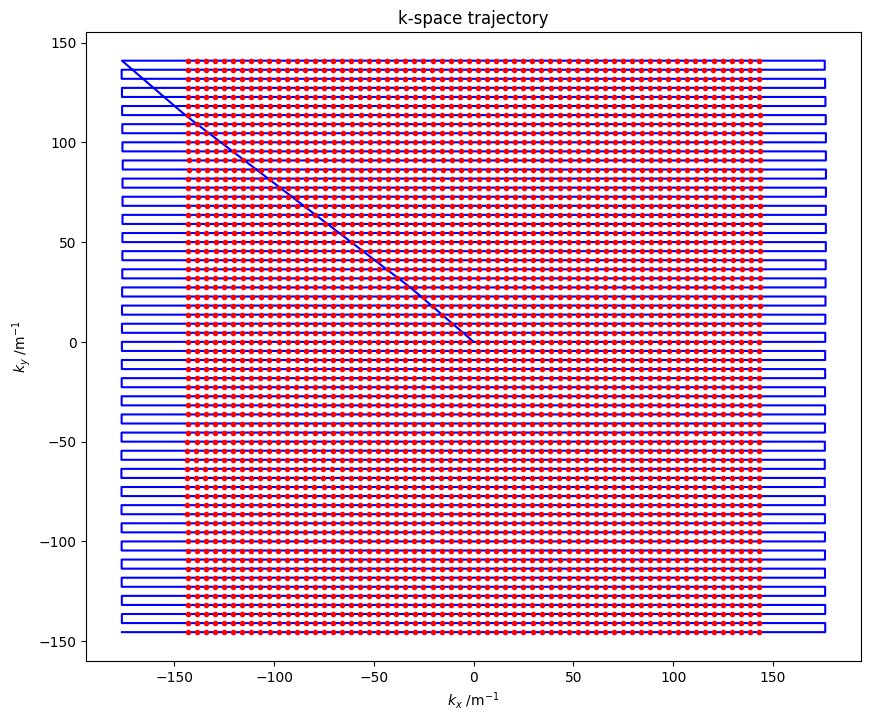

In [8]:
[k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc] = seq_list[1].calculate_kspace()
plt.figure(figsize=(10, 10))
plt.plot(k_traj[0,],k_traj[1,], 'b-')
plt.plot(k_traj_adc[0,],k_traj_adc[1,], 'r.')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.title('k-space trajectory')
plt.xlabel(r'$k_x \mathregular{\ /m^{-1}}$')
plt.ylabel(r'$k_y \mathregular{\ /m^{-1}}$')
plt.draw()

# (Optionally) Analyze the sequence
Very optional slow step, but useful for testing during development
e.g. for the real TE, TR or for staying within slew-rate limits, etc.

In [9]:
rep = seq.test_report()
print(rep)

Number of blocks: 129
Number of events:
RF:      1
Gx:     65
Gy:     64
Gz:      2
ADC:     64
Delay:      0
Sequence duration: 0.054450 s
TE: 0.027130 s
TR: 0.054450 s
Flip angle: 90.00 deg
Unique k-space positions (aka cols, rows, etc.): 64 64 
Dimensions: 2
Spatial resolution: 3.49 mm
Spatial resolution: 3.44 mm
Repetitions/slices/contrasts: 1.0; range: [(1.0, 1.0)]
Cartesian encoding trajectory detected
Event timing check failed. Error listing follows:
 ['Event: 3 - [type: adc delay: 110.00000000000007 us dwell: 8124.999999999999 ns]\n', 'Event: 5 - [type: adc delay: 110.00000000000007 us dwell: 8124.999999999999 ns]\n', 'Event: 7 - [type: adc delay: 110.00000000000007 us dwell: 8124.999999999999 ns]\n', 'Event: 9 - [type: adc delay: 110.00000000000007 us dwell: 8124.999999999999 ns]\n', 'Event: 11 - [type: adc delay: 110.00000000000007 us dwell: 8124.999999999999 ns]\n', 'Event: 13 - [type: adc delay: 110.00000000000007 us dwell: 8124.999999999999 ns]\n', 'Event: 15 - [type: adc 

#Write the .seq file

Set the output parameters (definitions) and write the sequence to the file.

*Note: The FOV definition is also used by the simulation/reconstruction code below*

In [10]:
# Prepare the sequence output for the scanner
seq.set_definition(key="FOV", value=[fov, fov, slice_thickness*n_slices])
seq.set_definition(key="Name", value="epi")
#
if write_seq:
  # Write the sequence file
  seq.write(seq_filename)
#  from google.colab import files
#  files.download(seq_filename)  # Download locally

#Animate trajectory

In [11]:
#if animate_seq:
#  ani = animate(seq, show=False, dt=1e-3, fps=5, show_progress=True) # additional paremeter: time_range=[start, end]
#  from IPython.display import HTML
#  display(HTML(ani.to_html5_video()))

**Run MR-zero simulation**

The code below simulates the whole sequence, and shows the magnitude of the raw k-space profiles.

In [12]:
#load cropped_phantom.mat
sim_filename = 'cropped_phantom.mat'

Calculating repetition 1 / 1 - done
Calculating repetition 1 / 1 - done
m 0
Calculating repetition 1 / 1 - done
m 1
Calculating repetition 1 / 1 - done
m 2
Calculating repetition 1 / 1 - done
m 3
Calculating repetition 1 / 1 - done
m 4
Calculating repetition 1 / 1 - done
m 5
Calculating repetition 1 / 1 - done
m 6
Calculating repetition 1 / 1 - done
m 7
Calculating repetition 1 / 1 - done
m 8
Calculating repetition 1 / 1 - done
m 9
Calculating repetition 1 / 1 - done
m 10
Calculating repetition 1 / 1 - done
m 11
Calculating repetition 1 / 1 - done
m 12
Calculating repetition 1 / 1 - done
m 13
Calculating repetition 1 / 1 - done
m 14
Calculating repetition 1 / 1 - done
m 15
Calculating repetition 1 / 1 - done
m 16
Calculating repetition 1 / 1 - done
m 17
Calculating repetition 1 / 1 - done
m 18
Calculating repetition 1 / 1 - done
m 19
Calculating repetition 1 / 1 - done
m 20
Calculating repetition 1 / 1 - done
m 21
Calculating repetition 1 / 1 - done
m 22
Calculating repetition 1 / 1 - 

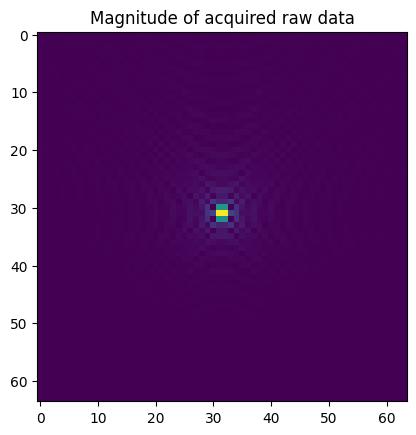

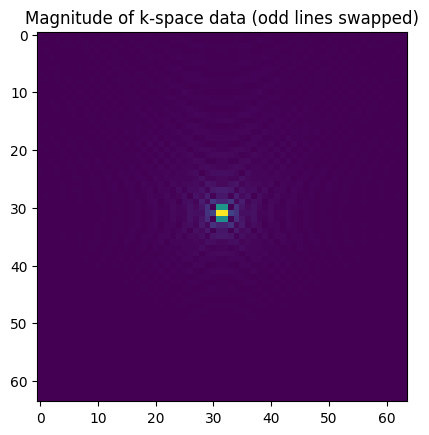

In [13]:
if simulate:
  # Simulate sequence
  #kdata = mr0.compute_graph(seq, obj_p, 200, 1e-3)
  #kdata2 = mr0.compute_graph(seq2, obj_p, 200, 1e-3)

  kdata = simulate_2d(seq, sim_size=[Nx*2,Ny*2], noise_level=0, n_coils=1) # B0_polynomial=[...] optional parameter: B0_offset, Gx, Gy, x^2, y^2, x*y; units??? good value 200
  kdata2 = simulate_2d(seq2, sim_size=[Nx*2,Ny*2], noise_level=0, n_coils=1)

  kdata_list = []
  for m in range(n_measurements):
    print('m',m)
  #for m in range(1):
    kdata_temp = simulate_2d(seq_list[m], sim_size=[Nx*2,Ny*2], noise_level=0, n_coils=1)
    kdata_list.append(kdata_temp)

  # Display raw data profiles
  plt.figure()
  plt.imshow(abs(kdata[0].reshape(-1,adc.num_samples)))
  plt.title('Magnitude of acquired raw data'); # raw data, not k-space data (odd/even lines not reverted)

  # Display the data more correctly
  kdata_swapped=np.zeros_like(kdata)
  kdata_swapped[:,0::2,:]=kdata[:,0::2,:]
  kdata_swapped[:,1::2,:]=kdata[:,1::2,::-1]
  plt.figure()
  plt.imshow(abs(kdata_swapped[0].reshape(-1,adc.num_samples)))
  plt.title('Magnitude of k-space data (odd lines swapped)'); # raw data, not k-space data (odd/even lines not reverted)


**Reconstruction**

Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 0
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 1
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


<ipython-input-14-f0d03142d510>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  rec_list[:,:,m] = rec_temp[::-1,::-1]


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 2
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 3
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 4
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 5
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 6
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 7
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 8
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 9
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 10
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 11
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 12
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 13
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 14
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 15
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 16
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 17
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 18
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 19
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 20
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 21
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 22
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 23
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 24
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 25
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 26
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 27
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 28
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 29
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 30
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 31
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 32
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 33
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 34
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 35
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 36
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 37
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 38
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 39
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 40
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 41
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 42
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 43
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 44
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 45
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 46
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 47
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 48
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 49
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 50
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 51
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 52
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 53
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 54
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 55
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 56
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 57
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 58
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 59
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 60
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 61
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 62
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 63
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 64
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 65
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 66
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 67
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 68
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 69
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 70
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 71
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 72
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 73
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 74
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 75
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 76
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 77
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 78
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 79
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 80
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 81
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 82
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 83
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 84
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 85
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 86
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 87
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 88
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 89
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 90
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 91
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 92
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 93
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 94
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 95
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 96
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 97
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

m 98
Automatically detected 2D sequence
Automatically detected matrix size: (66, 64)


LinearLeastSquares:   0%|          | 0/10 [00:00<?, ?it/s]

test


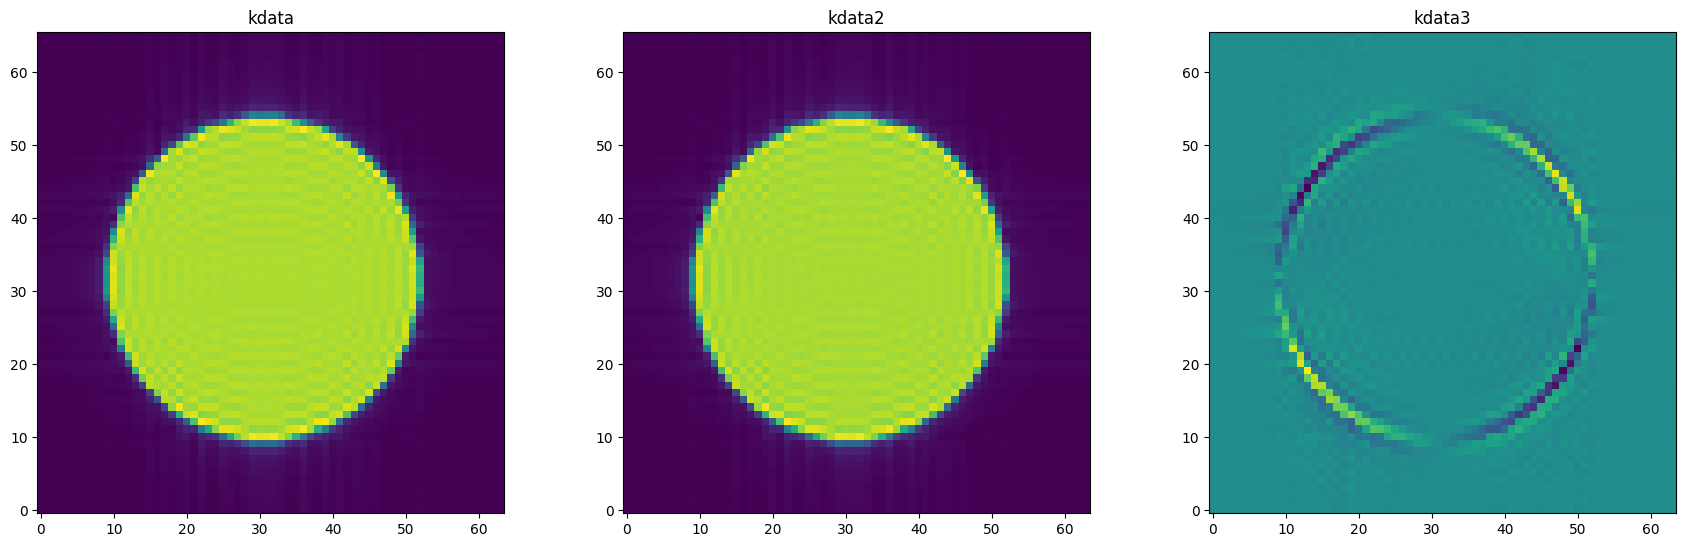

In [14]:
if simulate:

  rec = reconstruct(kdata, seq, trajectory_delay=0e-6, cartesian=False) # for the trajectory delay to work with the basic (non-ramp-sampling EPI) cartesian=False is needed
  # need to invert data dimentions because the reconstruction code uses iFFT to go from k-space to image space
  rec=rec[::-1,::-1]

  rec2 = reconstruct(kdata2, seq, trajectory_delay=0e-6, cartesian=False) # for the trajectory delay to work with the basic (non-ramp-sampling EPI) cartesian=False is needed
  # need to invert data dimentions because the reconstruction code uses iFFT to go from k-space to image space
  rec2=rec2[::-1,::-1]

  rec_list = np.zeros((66,64,n_measurements))
  for m in range(n_measurements):
    print('m',m)
    kdata_temp = kdata_list[m]
    rec_temp = reconstruct(kdata_temp, seq, trajectory_delay=0e-6, cartesian=False)
    rec_list[:,:,m] = rec_temp[::-1,::-1]
    #rec_list.append(rec_temp)

  #rec_list = np.load('recon_list_CimaX.npy')

  fig, ax = plt.subplots(nrows=1, ncols=3)
  ax = ax.flatten()

  ax[0].imshow(abs(rec), origin='lower')
  #ax[0].imshow(abs(rec_list[:,:,10]), origin='lower')
  ax[0].set_title('kdata')

  #ax[1].imshow(abs(rec_list[:,:,61]), origin='lower')
  ax[1].imshow(abs(rec2), origin='lower')
  ax[1].set_title('kdata2')
  print('test')
  ax[2].imshow(abs(rec2)-abs(rec), origin='lower')
  #ax[2].imshow(abs(rec_list[:,:,10])-abs(rec_list[:,:,61]), origin='lower')
  ax[2].set_title('kdata3')

  fig.tight_layout()
  fig.set_figheight(6)
  fig.set_figwidth(18)
  plt.show();


In [15]:
np.save('recon_list_CimaX.npy',rec_list)

from scipy.io import savemat

savemat('recon_list_CimaX.mat', {'recon_list_CimaX': rec_list})



# Exercises (getting familiar with EPI)
* **Familiarize yourself with the sequence**: find parameters to control FOV, spatial resolution, slice number and thickness, and readout bandwidth.
* **Implement an additional option for suppressing / inverting phase encoding**: one posibility is to add a switch `pe_switch` or similar variable to the "high-level sequence parameters" section taking values of (1,0,-1) and implement necessary code alternations. Known limitation of the code: the the image reconstruction will crash without phase encoding.
* **Experiment with B0_polynomial and pe_switch**, modify echo spacing by testing various values of `ro_duration` and visualize geometric distortions. Enhance distordion appearence by inverting the PE sign. `B0_polynomial` is an optional parameter to the `simulate_2d()` call and can be specified as `B0_polynomial=[0,0,0,0,0,0]`. The later setting will also reset the default (measured) B0 field map provided with the phantom data set. Setting any of the values in the array to non-zeros will induce corresponding spatial field term, see the comment to the `simulate_2d()` call.  
* **Check yourself**
  1. What is the native Pulseq unit for the gradient strength?
  2. Can you read the current spatial resolution from the k-space plot?
  3. What is the Pulseq native unit for the RF amplitude?
  4. Why certain combinations of matrix size and readout duration are not possible?
